In this notebook, we will build a Vision Transformers approach (ViT) that is trying to answer, given a query image and a set of candidate images, which images are the most similar to the query image.

## Some history

Traditional approaches to deep learning for computer vision primarily revolve around convolutional neural networks (CNNs). However, with the introduction of the transformer architecture by Vaswani et al. (2017) for natural language processing tasks, researchers began to explore its application in the field of computer vision.



The Vision Transformer (ViT) is one of the first attempts to directly apply a transformer to image classification tasks. Instead of using CNNs to extract local features from images, ViT treats images as a sequence of patches, much like a transformer treats text as a sequence of words or subwords.



## The Dataset

We will use a dataset from hugging face: called beans to search a query bean in a set of beans and we will display the "closest" candidates

In [ ]:
!pip install datasets

In [5]:
from datasets import load_dataset
dataset=load_dataset("beans")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/1034 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/133 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/128 [00:00<?, ? examples/s]

Dataset beans downloaded and prepared to /root/.cache/huggingface/datasets/beans/default/0.0.0/90c755fb6db1c0ccdad02e897a37969dbf070bed3755d4391e269ff70642d791. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
dataset["train"]

Dataset({
    features: ['image_file_path', 'image', 'labels'],
    num_rows: 1034
})

In [7]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the images
img1 = Image.open(dataset["train"]["image_file_path"][0])
img2 = Image.open(dataset["train"]["image_file_path"][1])

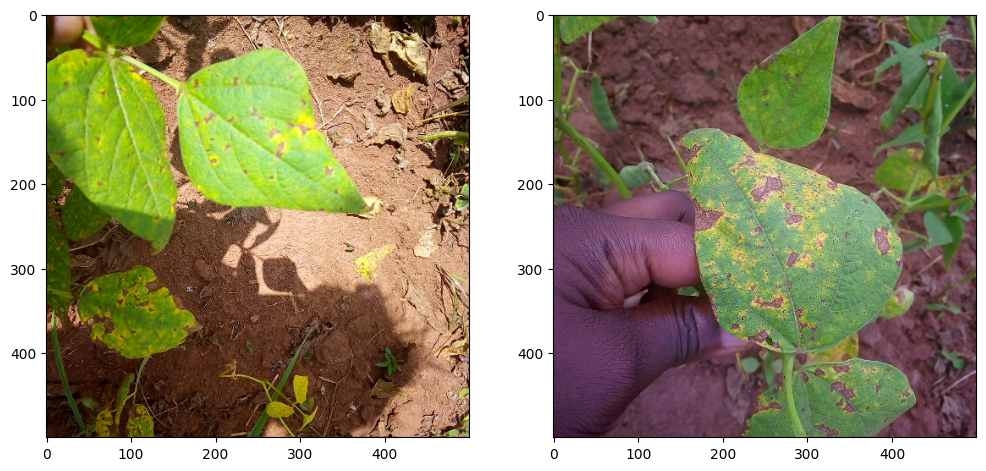

In [8]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))  # Adjust the size as necessary

# Show the images
ax1.imshow(img1)
ax2.imshow(img2)


## The candidates dataset

To demonstrate the image similarity system, we'll use 100 samples from the candidate image dataset to keep the overall runtime short.



In [9]:
num_samples = 100
seed = 42
candidate_subset = dataset["train"].shuffle(seed=seed).select(range(num_samples))

## Embeddings

We'll use **embeddings** to represent images in vector space. This gives us a nice way to meaningfully compress the high-dimensional pixel space of images (224 x 224 x 3, for example) to something much lower dimensional (768, for example). The primary advantage of doing this is the reduced computation time in the subsequent steps as well as removing the pixel-by-pixel comparison approach (embeddings from transformers should encompass the meanings behind an image regardless of the order of the pixels)

In [10]:
import torch 

def extract_embeddings(model: torch.nn.Module):
    """Utility to compute embeddings."""
    device = model.device

    def pp(batch):
        images = batch["image"]
        # `transformation_chain` is a compostion of preprocessing
        # transformations we apply to the input images to prepare them
        # for the model.
        image_batch_transformed = torch.stack(
            [transformation_chain(image) for image in images]
        )
        new_batch = {"pixel_values": image_batch_transformed.to(device)}
        with torch.no_grad():
            embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()
        return {"embeddings": embeddings}

    return pp


To compute the embeddings from the images, we'll use a vision model that has some understanding of how to represent the input images in the vector space. This type of model is also commonly referred to as image encoder.

For loading the model, we leverage the AutoModel class. It provides an interface for us to load any compatible model checkpoint from the Hugging Face Hub. Alongside the model, we also load the processor associated with the model for data preprocessing.



In [12]:
!pip install transformers

from transformers import AutoFeatureExtractor, AutoModel


model_ckpt = "nateraw/vit-base-beans"
extractor = AutoFeatureExtractor.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt)


/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Some weights of the model checkpoint at nateraw/vit-base-beans were not used when initializing ViTModel: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at nateraw/vit-base-beans and are newly initialized: ['vit.pooler.dense.weight', 'vit.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
import torchvision.transforms as T


# Data transformation chain.
transformation_chain = T.Compose(
    [
        # We first resize the input image to 256x256 and then we take center crop.
        T.Resize(int((256 / 224) * extractor.size["height"])),
        T.CenterCrop(extractor.size["height"]),
        T.ToTensor(),
        T.Normalize(mean=extractor.image_mean, std=extractor.image_std),
    ]
)

In [15]:
batch_size = 24

device = "cuda" if torch.cuda.is_available() else "cpu"
extract_fn = extract_embeddings(model.to(device))
candidate_subset_emb = candidate_subset.map(extract_fn, batched=True, batch_size=batch_size)


Map:   0%|          | 0/100 [00:00<?, ? examples/s]

We'll use cosine similarity to compute the similarity score in between two embedding vectors. We'll then use it to fetch similar candidate samples given a query sample.



In [16]:
def compute_scores(emb_one, emb_two):
    """Computes cosine similarity between two vectors."""
    scores = torch.nn.functional.cosine_similarity(emb_one, emb_two)
    return scores.numpy().tolist()


def fetch_similar(image, top_k=5):
    """Fetches the `top_k` similar images with `image` as the query."""
    # Prepare the input query image for embedding computation.
    image_transformed = transformation_chain(image).unsqueeze(0)
    new_batch = {"pixel_values": image_transformed.to(device)}

    # Comute the embedding.
    with torch.no_grad():
        query_embeddings = model(**new_batch).last_hidden_state[:, 0].cpu()

    # Compute similarity scores with all the candidate images at one go.
    # We also create a mapping between the candidate image identifiers
    # and their similarity scores with the query image.
    sim_scores = compute_scores(all_candidate_embeddings, query_embeddings)
    similarity_mapping = dict(zip(candidate_ids, sim_scores))
 
    # Sort the mapping dictionary and return `top_k` candidates.
    similarity_mapping_sorted = dict(
        sorted(similarity_mapping.items(), key=lambda x: x[1], reverse=True)
    )
    id_entries = list(similarity_mapping_sorted.keys())[:top_k]

    ids = list(map(lambda x: int(x.split("_")[0]), id_entries))
    labels = list(map(lambda x: int(x.split("_")[-1]), id_entries))
    return ids, labels


Next, for convenience, we create a list containing the identifiers of the candidate images.



In [19]:
candidate_ids = []

for id in range(len(candidate_subset_emb)):
    label = candidate_subset_emb[id]["labels"]

    # Create a unique indentifier.
    entry = str(id) + "_" + str(label)

    candidate_ids.append(entry)


We'll use the matrix of the embeddings of all the candidate images for computing the similarity scores with a query image. We have already computed the candidate image embeddings. In the next cell, we just gather them together in a matrix.



In [21]:
import numpy as np

all_candidate_embeddings = np.array(candidate_subset_emb["embeddings"])
all_candidate_embeddings = torch.from_numpy(all_candidate_embeddings)


Given all the utilities, we're equipped to do a similarity search. Let's have a query image from the test split of the beans dataset:



In [22]:
test_idx = np.random.choice(len(dataset["test"]))
test_sample = dataset["test"][test_idx]["image"]
test_label = dataset["test"][test_idx]["labels"]

sim_ids, sim_labels = fetch_similar(test_sample)
print(f"Query label: {test_label}")
print(f"Top 5 candidate labels: {sim_labels}")

Query label: 1
Top 5 candidate labels: [1, 1, 1, 1, 1]


We can notice that given the query image, candidate images having similar labels were fetched.


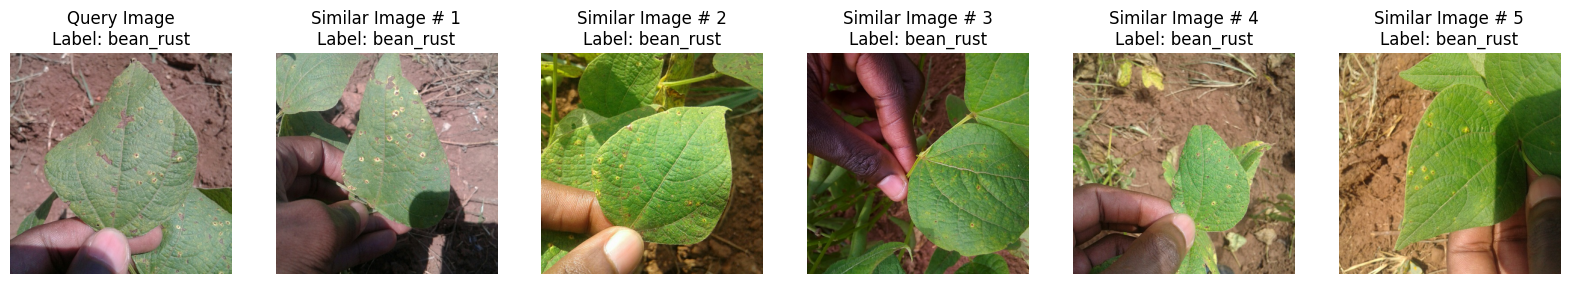

In [28]:
import matplotlib.pyplot as plt

labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()

for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

def plot_images(images, labels):
    if not isinstance(labels, list):
        labels = labels.tolist()

    plt.figure(figsize=(20, 10))
    columns = 6
    for (i, image) in enumerate(images):
        label_id = int(labels[i])
        ax = plt.subplot(int(len(images) / columns + 1), columns, i + 1)
        if i == 0:
            ax.set_title("Query Image\n" + "Label: {}".format(id2label[label_id]))
        else:
            ax.set_title(
                "Similar Image # " + str(i) + "\nLabel: {}".format(id2label[label_id])
            )
        plt.imshow(np.array(image).astype("int"))
        plt.axis("off")


images = []
labels = []

for id, label in zip(sim_ids, sim_labels):
    images.append(candidate_subset_emb[id]["image"])
    labels.append(candidate_subset_emb[id]["labels"])

images.insert(0, test_sample)
labels.insert(0, test_label)
plot_images(images, labels)